In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42
video_path = 'data_generated/R25_gray_scaled.mp4'

##  Comparison of methods for 30 seconds video

### PCA

In [4]:
video = VideoLoader(video_path, gray=True, duration=10, torch=False)
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)

reconstructed = video.reduce_latent(model_pca)
print('L2-error of reconstruction:', reconstruction_error(reconstructed, all_frames.reshape(video.duration_frames, video.height, video.width)))

L2-error of reconstruction: 4.31239583539246


In [31]:
write_video('data_generated/week7/R25_pca_10comp.mp4', reconstructed, video)

### Autoencoders

In [2]:
models = torch.load('data_generated/week7/models.pth')

## Models

In [3]:
video_train = VideoLoader(video_path, duration=30, gray=True)
video_test =  VideoLoader(video_path, start=30, duration=10, gray=True)
meta = {'w': video_train.width, 
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
args = [((1, meta['w'], meta['h']), 50), ((1, meta['h'], meta['w']), 10), 
        (1, 2, 32), (1, 2, 32, 10)]
model_constructors = [PCAAutoEncoder, OneHAutoEncoder, TemporalConvAE, TemporalConvAE]
for m, a in zip(model_constructors, args):
    print(m(*a))
    print('-'*70)

PCAAutoEncoder(
  (to_lower_rep): Linear(in_features=65536, out_features=50, bias=True)
  (from_lower_rep): Linear(in_features=50, out_features=65536, bias=True)
)
----------------------------------------------------------------------
OneHAutoEncoder(
  (to_lower_rep): Sequential(
    (0): Linear(in_features=65536, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (from_lower_rep): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=65536, bias=True)
  )
)
----------------------------------------------------------------------
TemporalConvAE(
  (encoder_convs): Sequential(
    (0): Conv3d(1, 32, kernel_size=(8, 8, 8), stride=(2, 2, 2))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(5, 7, 7), stride=(1, 2, 2))
    (3): ReLU()
  )
  (decoder_convs): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(5, 7, 7), stride=(1, 2, 2))
    (1

In [7]:
def train_helper(model_key, base_model, model_args, video, lrs, models, num_epoch_tune=10, num_epoch=40):
    iteration_per_epoch = int(video.duration_frames/video.batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device', device)
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        
    losses_tune = []
    for lr in lrs:
        if len(lrs) == 1:
            losses_tune.append(0)
            break
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = base_model(*model_args).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
        if len(losses_tune) >= 2 and losses_tune[-1] > losses_tune[-2]:
            break
    lr = lrs[np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = base_model(*model_args).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
            print(f'\t Error at epoch {epoch+1}:', losses[-1])
    
    model_dict = {
        'model': model.state_dict(),
        'epoch': num_epoch,
        'optimizer': optimizer.state_dict(),
        'lr': lr,
        'losses_tune': losses_tune,
        'lrs': lrs,
        'losses': losses,
        'epoch_time': (time()-t1)/num_epoch
    }
    models[model_key] = model_dict
    return model

def evaluate_model(model, model_key, models, meta):
    reconstructed_train = video_train.reduce_latent(model, trans=False)
    reconstructed_test = video_test.reduce_latent(model, trans=False)
    original_frames_train_ = original_frames_train.numpy().reshape(-1, *video_train.sample_shape)
    original_frames_test_  = original_frames_test.numpy().reshape(-1, *video_test.sample_shape)
    models[key]['train_error'] = reconstruction_error(original_frames_train_, reconstructed_train.numpy())
    models[key]['test_error'] = reconstruction_error(original_frames_test_, reconstructed_test.numpy())
    print('Training error:', models[key]['train_error'])
    print('Testing error:', models[key]['test_error'])
    reconstructed_train_ = reconstructed_train.numpy().reshape(-1, video_train.height, video_train.width)
    write_video(key+'.mp4', reconstructed_train_, meta['w'], meta['h'], meta['fps'], meta['gray'])
    print('Video for '+key+' written')

video_train = VideoLoader(video_path, duration=30, gray=True)
video_test =  VideoLoader(video_path, start=30, duration=10, gray=True)
meta = {'w': video_train.width, 
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
original_frames_train = video_train.get_all_frames()
original_frames_test = video_test.get_all_frames()
num_epoch, num_epoch_tune = 40, 10
models = {}

#### Results

In [93]:
models = torch.load('data_generated/week7/models.pth', map_location=torch.device('cpu'))

In [96]:
losses = [m['losses'] for m in models.values()]
max_epoch = max([m['epoch'] for m in models.values()])
losses.append([4.559068042234817]*max_epoch)
xs = [range(1, m['epoch']+1) for m in models.values()] + [range(1, max_epoch+1)]
labels = [l for l in models.keys()] + ['PCA']

Final error for 10-TempConvAE:
	Training: 16.865911
	Testing: 18.43578

Final error for 50-PCAAE:
	Training: 31.42559
	Testing: 30.344513

Final error for 10-OneHAE:
	Training: 14.447613
	Testing: 15.870127

Final error for TempConvAE:
	Training: 10.37117
	Testing: 10.157935



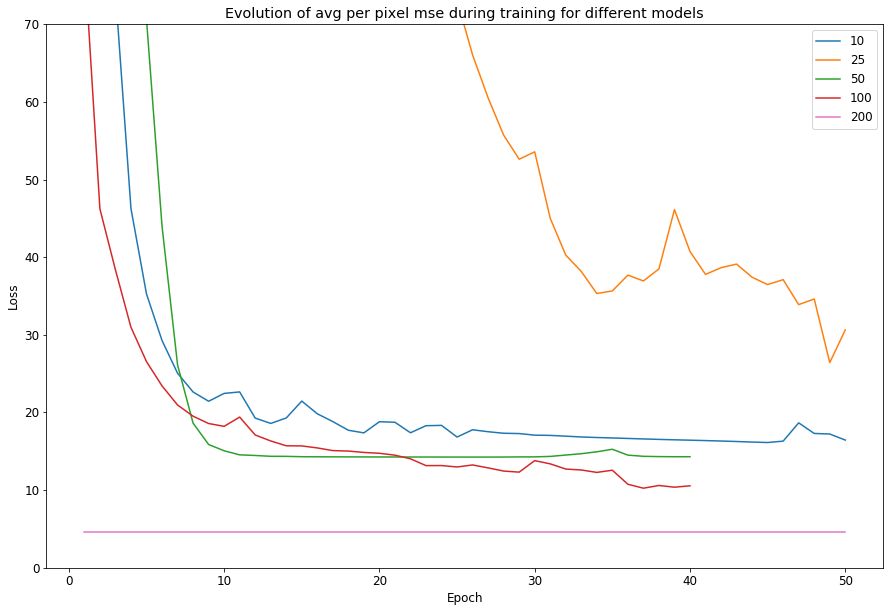

In [107]:
plot(xs, losses, labels=labels, title="Evolution of avg per pixel mse during training of 30 seconds of experience video",
    xlabel='Epoch', ylabel='Loss', yrange=(0, 70))
plt.savefig('data_generated/week7/losses_all_models.png')
for k, m in models.items():
    print('Final error for %s:' % k)
    print('\tTraining:', m['train_error'])
    print('\tTesting:', m['test_error'])
    print()

## Spatio-temporal convolutional autoencoder, latent dimension comparison

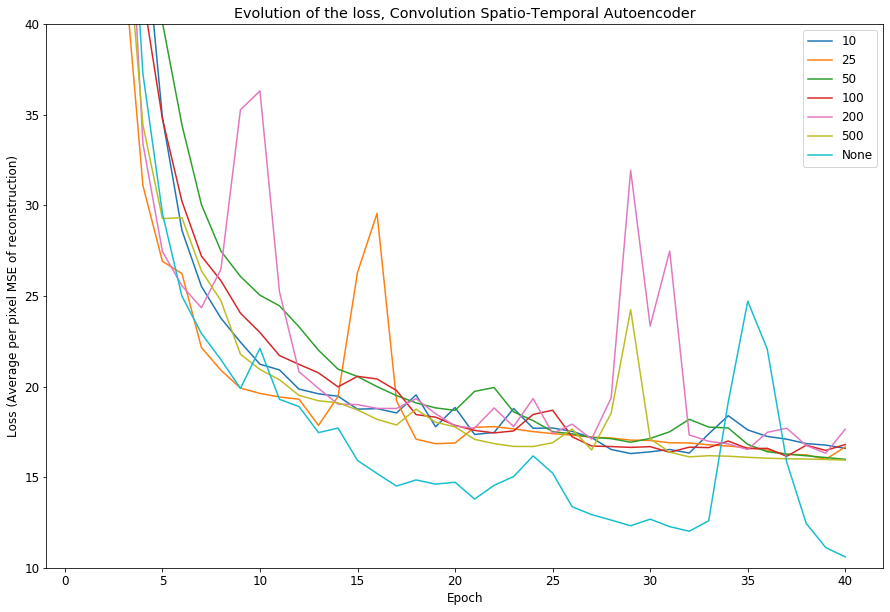

In [104]:
with open('data_generated/all_losses_from_colab_2.json', 'r') as fp:
    all_losses = json.load(fp)

ys = [l for _, l in all_losses.values()]
labels = [l for l in all_losses.keys()]

plot(range(1, 41), ys, labels=labels, yrange=(10, 40), 
     title='Evolution of the loss, Convolution Spatio-Temporal Autoencoder', xlabel='Epoch', ylabel='Loss (Average per pixel MSE of reconstruction)')
plt.savefig('data_generated/week7/losses_latent_dim.png')

## Dynamical system integration

In [4]:
video = video_train

### Baseline

In [5]:
video.torch = False
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)

In [6]:
frames_enc, shape = model_pca.encode(all_frames)
A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
print(frames_enc.shape, A.shape)

(960, 10) (10, 10)


In [7]:
Y_pred = model_pca.decode(frames_enc[:-1]@A)
error_pca = reconstruction_error(Y_pred, all_frames[1:])
error_pca, reconstruction_error(all_frames, model_pca.decode(frames_enc))

(4.557770445664049, 4.559068042234817)

### PCA jointly optimized, initialized with the baseline transformation

In [8]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

#### Training

In [12]:
video.torch = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using',torch.cuda.get_device_name(device))
np.random.seed(seed)
torch.manual_seed(seed)
model = PCAAutoEncoder((1, meta['h'], meta['w']), 10).to(device)

# Initialize weights as PCA model
state_dict = model.state_dict()
state_dict['to_lower_rep.weight'] = torch.from_numpy(model_pca.pc.T).to(device)
state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
state_dict['from_lower_rep.weight'] = torch.from_numpy(model_pca.pc).to(device)
state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
model.load_state_dict(state_dict)
mean,std = model_pca.mean, model_pca.std
"""
Comparison between PCAAE and real PCA

all_frames = video.get_all_frames().to(device)
all_frames_std = standardize_frames(all_frames)
all_frames_enc = model.encode(all_frames_std)
Y_rec  = model.decode(all_frames_enc).detach().cpu().numpy()
A_torch = torch.from_numpy(A).float().to(device)
Y_pred = model.decode(all_frames_enc[:-1]@A_torch).detach().cpu().numpy()
error_pred = reconstruction_error(Y_pred*std+mean, all_frames_std[:-1].cpu().numpy())
error_rec = reconstruction_error(Y_rec*std+mean, all_frames.cpu().numpy())
print(error_pred, error_rec)

all_frames_std_np = all_frames_std.detach().cpu().numpy()
other_rec = (all_frames_std.view(-1, 256*256) @ state_dict['to_lower_rep.weight'].T.float()) @ state_dict['from_lower_rep.weight'].T.float()
other_rec1 = (all_frames_std.view(-1, 256*256).numpy() @ custom_pca.pc) @ custom_pca.pc.T.float()
print(crit(all_frames, other_rec.reshape(all_frames.shape)))
"""
model_ds = FramePredictor(model).to(device)

lr1 = 0.05
optimizer1 = Adam(model_ds.parameters(), lr=lr1)
for epoch in range(10):
    if epoch == 2:
        optimizer1 = Adam(model_ds.parameters(), lr=lr1/5)
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean
        
        loss = crit(frames_next, frames_next_gt)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    print(loss.item())

Using Tesla P100-PCIE-12GB


NameError: name 'ae' is not defined

In [338]:
torch.save(model.state_dict(), 'pcaae.pth')
torch.save(model_ds.state_dict(), 'ds.pth')

In [344]:
model_ds.load_state_dict(torch.load('ds.pth'))
model_ds.to(device)
model.load_state_dict(torch.load('pcaae.pth'))
model.to(device)

lr2 = 0.00005
optimizer2 = Adam(list(model.parameters())+list(model_ds.parameters()), lr=lr2)
optimizer0 = Adam(model.parameters(), lr=lr2)
optimizer1 = Adam(model_ds.parameters(), lr=lr2)
"""
for epoch in range(num_epoch):
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)

        if (epoch//2) %2 == 0:
            optimizer0.zero_grad()
            loss.backward()
            optimizer0.step()
        else:
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()
    print(f'Epoch {epoch+1}:', loss.item())
    """
for epoch in range(5):
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
    print(f'Epoch {epoch+1}:', loss.item())

Epoch 1: 7.6391425132751465
Epoch 2: 7.515155792236328
Epoch 3: 7.499922752380371
Epoch 4: 7.547431468963623
Epoch 5: 7.492400169372559


#### Comparison between PCAAE and real PCA

In [14]:
all_frames_rec_ae_std.shape, all_frames_std.shape

(torch.Size([960, 1, 256, 256]), torch.Size([960, 256, 256]))

In [29]:
all_frames = video.get_all_frames().to(device)
all_frames_std = standardize_frames(all_frames)
nf = video.duration_frames

#Custom PCA
all_frames_rec_pca0_std = torch.from_numpy(model_pca.decode(*model_pca.encode(all_frames_std.view(-1, 256*256).cpu().numpy())))
error_rec_pca0 = crit(all_frames_rec_pca0_std*std+mean, all_frames.reshape(nf, -1).detach().cpu())

# PCA
all_frames_rec_pca_std = torch.from_numpy((all_frames_std.view(-1, 256*256).cpu().numpy() @ model_pca.pc) @ model_pca.pc.T)
error_rec_pca = crit(all_frames_rec_pca_std*std+mean, all_frames.reshape(nf, -1).detach().cpu())

# AE
all_frames_rec_ae_std = model(all_frames_std)
error_rec_ae = crit(all_frames_rec_ae_std.squeeze()*std+mean, all_frames)
print(error_rec_ae, error_rec_pca, error_rec_pca0)

all_frames_std_np = all_frames_std.detach().cpu().numpy()
other_rec = (all_frames_std.view(-1, 256*256) @ state_dict['to_lower_rep.weight'].T.float()) @ state_dict['from_lower_rep.weight'].T.float()
other_rec1 = (all_frames_std.view(-1, 256*256).cpu().numpy() @ model_pca.pc) @ model_pca.pc.T
print(crit(all_frames, other_rec.reshape(all_frames.shape)*std+mean))
print(crit(all_frames, other_rec1.reshape(all_frames.shape)))

tensor(8.1053, device='cuda:0', grad_fn=<SqrtBackward>) tensor(8.1053, dtype=torch.float64) tensor(7152.2461)
tensor(8.1053, device='cuda:0')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [231]:
mean,std = model_pca.mean, model_pca.std
all_frames_std = standardize_frames(video.get_all_frames(), mean=mean, std=std)
frames_rec = model.cpu()(all_frames_std)
frames_rec = np.clip(np.around((frames_rec*std+mean).detach().cpu().numpy()), 0, 255).astype(np.uint8).squeeze()

print('Error:', reconstruction_error(frames_rec, all_frames.numpy()))

Error: 8.109928


##### Test to see if setting of parameters does what we expect

In [68]:
m = nn.Linear(3, 2)
d = m.state_dict()
w = torch.tensor([[1, 1, 1], [0, 1, 0]])
print(w.shape)
d['weight'] = w
d['bias'] = torch.zeros(2)
m.load_state_dict(d)

m(torch.ones(4,3))

torch.Size([2, 3])


tensor([[3., 1.],
        [3., 1.],
        [3., 1.],
        [3., 1.]], grad_fn=<AddmmBackward>)

In [134]:
all_frames = video.get_all_frames()
mean, std = model_pca.mean, model_pca.std
print(mean, std, all_frames.mean().item(), all_frames.std().item())
all_frames_std = standardize_frames(all_frames, mean=mean, std=std)
print(all_frames_std.mean().item(), all_frames_std.std().item())
frames_reduced_1, _ = model_pca.encode(all_frames.numpy())
frames_reduced_2 = model.cpu().encode(all_frames_std)
frames_rec_1 = model_pca.decode(frames_reduced_1)
frames_rec_2 = model.decode(frames_reduced_2)
print(frames_reduced_1[10]-frames_reduced_2[10].detach().cpu().numpy())
print(frames_rec_1[10][1000:1030] - np.clip((frames_rec_2.view(all_frames.shape[0], -1)[10][1000:1030]*std+mean).detach().cpu().numpy(), 0, 255).astype(np.uint8))

143.8216324488322 59.16072062729064 143.82162475585938 59.16072082519531
-1.2814999195143173e-07 1.0
[ 4.08673879e-05 -8.35092846e-07  2.44171119e-06 -2.07743643e-07
  1.04351250e-06 -2.36703182e-06  1.18142955e-05  1.22019389e-05
  8.20599223e-06 -3.66245938e-06]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [200]:
frec1 = frames_rec_1
frec2 = (frames_rec_2.view(all_frames.shape[0], -1)*std+mean).detach().cpu().numpy()
diffs = frames_rec_1.reshape(-1) - np.clip(frec1, 0, 255).astype(np.uint8).reshape(-1)
npw =  np.argwhere(diffs != 0)

In [220]:
frames_rec - frec1.reshape(960,256,256)

array([[[  0,   0,   1, ..., 115, 115, 115],
        [  0,   1,   1, ..., 116, 116, 117],
        [  1,   1,   0, ..., 118, 119, 119],
        ...,
        [143, 141, 139, ...,   0,   0,   0],
        [143, 141, 139, ...,   0,   0,   0],
        [142, 141, 138, ...,   0,   0,   0]],

       [[  1,   0,   0, ..., 132, 132, 132],
        [  0,   0,   1, ..., 133, 133, 132],
        [  0,   1,   1, ..., 134, 134, 134],
        ...,
        [126, 125, 124, ...,   1,   1,   1],
        [126, 125, 124, ...,   1,   1,   1],
        [126, 125, 124, ...,   1,   1,   1]],

       [[  1,   1,   1, ..., 133, 133, 133],
        [  1,   0,   1, ..., 135, 134, 134],
        [  0,   0,   1, ..., 135, 135, 135],
        ...,
        [124, 123, 122, ...,   1,   0,   1],
        [124, 123, 122, ...,   0,   1,   1],
        [124, 123, 122, ...,   1,   0,   0]],

       ...,

       [[  1,   1,   1, ..., 125, 126, 126],
        [  1,   1,   1, ..., 125, 126, 126],
        [  1,   0,   0, ..., 125, 126, 127

In [195]:
print(9)
for i in npw.reshape(-1):
    print(diffs[i-2:i+2])
    frec1, frec2 = frec1.reshape(-1), frec2.reshape(-1)
    print(frec1[i], frec2[i], frec1[i]-frec2[i], np.clip(frec1[i], 0, 255), np.clip(frec1[i], 0, 255)-frec2[i])
    #print(np.clip(frec2.reshape(-1)[i-5:i+5], 0, 255).astype(np.uint8), frames_rec_1.reshape(-1)[i-5:i+5]-np.clip(frec2.reshape(-1)[i-5:i+5], 0, 255).astype(np.uint8))
    #print(*zip(frec1[i-5:i+5], frec2.reshape(-1)[i-5:i+5], diffs[i-5:i+5]))
    break

9


### Using OneH network for compression

In [10]:
video.torch = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### One hidden layer autoencoder with initialization as after training of compression model

In [ ]:
model = OneHAutoEncoder((1, meta['h'], meta['w']), 10)
model.load_state_dict(models['10-OneHAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.0005)
for epoch in range(20):
    for frames in video:
        frames = frames.to(device)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames[:-1])
        frames_next = model.decode(model_ds(frames_enc))
        loss = crit(frames_next, frames_next_gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

### Using spatio-temporal convolutional network for compression

#### Convert the model from models.pth

In [17]:
models = torch.load('data_generated/week7/models.pth')
d = models['10-TempConvAE']['model']

In [19]:
d["to_lower_rep.weight"] = d["low_dim_mapping.0.weight"]
d["to_lower_rep.bias"] =   d["low_dim_mapping.0.bias"]
d["from_lower_rep.weight"] = d["low_dim_mapping.1.weight"]
d["from_lower_rep.bias"] = d["low_dim_mapping.1.bias"]
del d["low_dim_mapping.0.weight"]
del d["low_dim_mapping.0.bias"]
del d['low_dim_mapping.1.weight']
del d['low_dim_mapping.1.bias']
del models['10-OneHAE']['little_modification']

In [22]:
torch.save(models, 'data_generated/week7/models.pth')

#### Train with initialization as after training of compression model

In [5]:
video = video_train
video.torch = True
temporal_batch_size = 16
video.sample_shape = (1, temporal_batch_size, meta['h'], meta['w'])
video.stride = 1
video.batch_size = 16

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalConvAE(1, 2, 32, 10)
model.load_state_dict(models['10-TempConvAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.0005)

torch.autograd.set_detect_anomaly(True)

for epoch in range(20):
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        x_pred = x
    
        if (i+1) % video.batch_size == 0:
            print(next(model.parameters())[0,0,0,0], next(model_ds.parameters())[0,0])
            print(i)
            optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            loss = 0
            optimizer.step()

    print(loss)

# Transform the video -> frames_enc
error = reconstruction_error(model_ds(frames_enc[:-1]), frames_enc[1:])

tensor([ 0.0308,  0.0337, -0.0134,  0.0376, -0.0127,  0.0059, -0.0245,  0.0230],
       device='cuda:0', grad_fn=<SelectBackward>) tensor(-0.0061, device='cuda:0', grad_fn=<SelectBackward>)
15
tensor([ 0.0308,  0.0337, -0.0134,  0.0376, -0.0127,  0.0059, -0.0245,  0.0230],
       device='cuda:0', grad_fn=<SelectBackward>) tensor(-0.0066, device='cuda:0', grad_fn=<SelectBackward>)
31


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [115200, 10]], which is output 0 of TBackward, is at version 3; expected version 2 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!